## Classifying deceptive reviews with topic models (python)

First let's import the necessary libraries.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, recall_score,precision_score, make_scorer,fbeta_score
from sklearn import svm, tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, train_test_split
from wordcloud import WordCloud
from collections import Counter
from itertools import combinations
from gensim import models,corpora,similarities
from nltk.util import ngrams
import string
import matplotlib.pyplot as plt
import re
import nltk

Now we're ready to extract the data and assign labels.

In [2]:
reviews = pd.read_csv('./input/deceptive-opinion.csv')
reviews_txt =  reviews['text']
    
labels = reviews['deceptive'].values
labels = (labels == 'truthful') * 1
labels = pd.Series(labels)
    
truthful_indices = labels[labels == 1].index.values
deceptive_indices = labels[labels == 0].index.values

truthful_txt = ' '.join(reviews_txt[truthful_indices].values).replace("\n"," ")
deceptive_txt = ' '.join(reviews_txt[deceptive_indices].values).replace("\n"," ")

num_docs = reviews_txt.shape[0]


### Single word analysis

Let's do some fancy visualisations. Are there any words which come up more frequently for either category?
First let's do the truthful reviews:

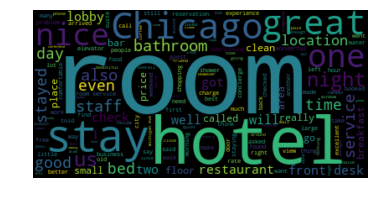

In [3]:
wordcloud = WordCloud().generate(truthful_txt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

How about deceptive reviews?

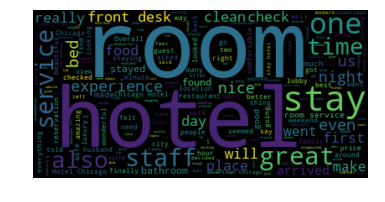

In [4]:
wordcloud = WordCloud().generate(deceptive_txt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Look fairly similar with possible exception of '*chicago*'.
What about word types? Any differences between categories in this regard?
For this we will need **nltk**'s comprehensive tools. 

First, let's look at **truthful** reviews.

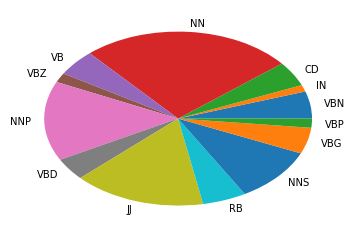

In [5]:
tokens = nltk.word_tokenize(truthful_txt)
tagged_tokens = nltk.pos_tag(tokens)

tags = Counter(dict(tagged_tokens).values()).keys()
freqs = Counter(dict(tagged_tokens).values()).values()
    
inds=np.where(np.array(list(freqs)) > 50)[0]
tags=np.array(list(tags))[inds]
freqs=np.array(list(freqs))[inds]

plt.pie(freqs, labels=tags)
plt.show()

Now let's look at **deceptive** reviews

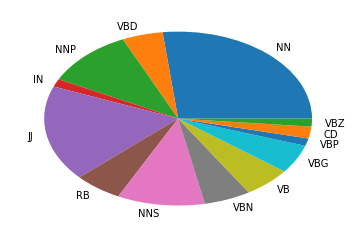

In [6]:
tokens = nltk.word_tokenize(deceptive_txt)
tagged_tokens = nltk.pos_tag(tokens)

tags = Counter(dict(tagged_tokens).values()).keys()
freqs = Counter(dict(tagged_tokens).values()).values()
    
inds=np.where(np.array(list(freqs)) > 50)[0]
tags=np.array(list(tags))[inds]
freqs=np.array(list(freqs))[inds]

plt.pie(freqs, labels=tags)
plt.show()

Unsurprisingly, the most prevalent word types are nouns for both categories. 

Does the occurrence of specific words carry information regarding whether a review is deceptive or not?

C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log
C:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply


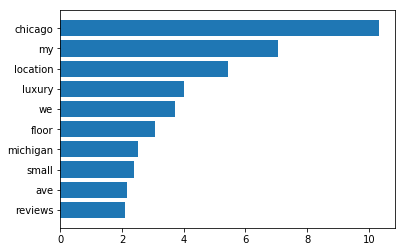

In [7]:
# first remove common words (pronouns etc) which are not informative in themselves

txt_removed = [None] * num_docs
freq = 50
num_bins = 50
for i in range(0,num_docs):
        
    common_words = 'a at for of the and to in & $'.split()
    
    words = reviews_txt[i].lower().split()
        
    txt_removed[i] = ' '.join([word for word in words if word not in common_words])
    
#to compute mutual information we need several components...
    
    
bins = np.zeros([num_docs,2])
  
p_c1 = float(len(truthful_indices)) / num_docs # the unconditional probability of getting a truthful review
    
p_c2 = float(len(deceptive_indices)) / num_docs # same but for deceptive reviews
    
p_c = np.array([[p_c1],[p_c2]])
    
type_entropy = -np.sum(p_c * np.log(p_c)) #unconditional entropy
    
ngram_counts = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1) # let's count all the words in the corpus
word_counts = ngram_counts.fit_transform(txt_removed)

num_words = len(ngram_counts.vocabulary_.values())

word_vocab = [None] * num_words

for n in range(0,num_words-1):
        
    index = np.array(list(ngram_counts.vocabulary_.values()))[n]
        
    word_vocab[index] = np.array(list(ngram_counts.vocabulary_.keys()))[n]
           
    
subset_indices = (np.where(np.sum(word_counts.toarray(),axis=0)>freq))[0]
    
word_vocab_subset = [word_vocab[i] for i in subset_indices]

word_counts_subset = word_counts[:,subset_indices]
    
num_words_subset = np.shape(word_counts_subset)[1]
    
info_gain = np.zeros(num_words_subset)
    
bins = range(0,num_bins)
    
for n in range(0,num_words_subset):
            
    p_wc = np.zeros((2,len(bins)-1)) # word likelihood given a category
        
    b, bin_edges = np.histogram(word_counts_subset[truthful_indices,n].toarray(),bins=bins)
        
    p_wc[0,:] = b.astype('float') / len(truthful_indices)
        
    b, bin_edges = np.histogram(word_counts_subset[deceptive_indices,n].toarray(),bins=bins)
        
    p_wc[1,:] = b.astype('float') / len(deceptive_indices)
        
    b, bin_edges = np.histogram(word_counts_subset[:,n].toarray(),bins=bins)
        
    p_w = b.astype('float') / num_docs
        
    p_cw = np.multiply(p_wc,p_c) / p_w # we finally get to calculate conditional probability of a category given a word
        
    conditional_entropy = -np.nansum((p_w * p_cw) * np.log(p_cw))
        
    info_gain[n] = ((type_entropy - conditional_entropy) / type_entropy) * 100
        
    names = np.array(word_vocab_subset)    
        
    info_per_word = dict(zip(names,info_gain)) # and now we have mutual info

# let's plot some stuff 

ranked_words = np.array(list(info_per_word.keys()))[np.argsort(list(info_per_word.values()))]
ranked_vals = np.array(list(info_per_word.values()))[np.argsort(list(info_per_word.values()))]

ranked_words_top10 = ranked_words[len(info_per_word)-10:len(info_per_word)]
ranked_vals_top10 = ranked_vals[len(info_per_word)-10:len(info_per_word)]

fig, ax = plt.subplots()
  
ax.barh(np.arange(10),np.array(ranked_vals_top10))
plt.rcdefaults()

ax.set_yticks(np.arange(10))
ax.set_yticklabels(ranked_words_top10)
plt.show()

Ultimately, there are no differences in terms of word frequencies and word types BUT there are still some highly informative words.
It appears that the most informative words are location-based (“Chicago”, “Michigan”) or even more abstract such as “location” and “ave” (short for avenue).
### Extracting topic vectors

With the preliminary analyses done we are ready to proceed with topic .
First let's tokenize each review to a bag of bigrams (two-word tokens) and remove bigrams which are uninformative in this context (e.g. "*at_the*", "*on_the*"). Why are we using bigrams you might ask? Because they perform better than single words as presented in the original study by Ott et al.

In [8]:
bigrams_docs = [None] * num_docs
    
acceptable_tags = ['CC','CD','DT','IN','EX','LS','MD','POS','PDT','RP','TO','WDT','WP','WRB','PRP$','PRP']               
    
tag_combos = [item for n,item in enumerate(combinations(acceptable_tags[::-1],2))] + [item for n,item in enumerate(combinations(acceptable_tags,2))]
translator = str.maketrans(dict.fromkeys(string.punctuation))

for i in range(0,num_docs):
        
    text=reviews_txt[i].lower().translate(translator)
        
    token = nltk.word_tokenize(text)
        
    bigrams = ngrams(token,2)
        
    valid_bigrams = [bigram for bigram in bigrams if tuple(dict(nltk.pos_tag(bigram)).values()) not in tag_combos]
    
    bigrams_docs[i] = ['_'.join(valid_bigrams[n]) for n,item in enumerate(valid_bigrams)]
    


print(bigrams_docs[7])

['just_got', 'got_back', 'back_from', '2_days', 'days_up', 'up_in', 'in_chicago', 'chicago_shopping', 'shopping_with', 'with_girlfriends', 'girlfriends_first', 'first_time', 'time_i', 'i_have', 'have_stayed', 'stayed_at', 'the_omni', 'omni_i', 'i_did', 'did_so', 'so_because', 'because_i', 'i_saw', 'saw_a', '12900_rate', 'rate_that', 'that_included', 'included_2500', 'of_free', 'free_food', 'food_on', 'on_travelzoo', '55_year', 'year_olds', 'olds_all', 'all_stayed', 'stayed_in', 'one_suite', 'suite_with', '2_double', 'double_beds', 'beds_and', 'a_very', 'very_comfortable', 'comfortable_pull', 'pull_out', 'out_sofa', 'sofa_we', 'we_had', 'had_plenty', 'plenty_of', 'of_room', 'room_food', 'food_in', 'the_restaurant', 'restaurant_was', 'was_great', 'great_service', 'service_was', 'was_outstanding', 'outstanding_from', 'from_everone', 'everone_we', 'we_came', 'came_into', 'into_contact', 'contact_with', 'with_early', 'early_morning', 'morning_delivery', 'delivery_of', 'of_free', 'free_coffe

Now that we've removed all unnecessary bigrams and tokenized each review let's move to forming the corpus for topic models.

In [9]:
dictionary=corpora.Dictionary(bigrams_docs)

corpus = [dictionary.doc2bow(text) for text in bigrams_docs]

With corpus and dictionary in hand we can move on to constructing the model. The hyperparameters, number of topics, chunksize and number of passes have been set to 100, 400 and 5. You will have to take my word. There was a lot of laborious grid-searching which preceded this..

In [10]:
num_topics = 100
chunksize = 400
passes = 5

model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics,alpha = 'auto',eta='auto',random_state=0, chunksize=chunksize, passes=passes)

In [11]:
topic_dists = np.zeros([num_docs,num_topics])
    
for i,item in enumerate(corpus):
        
    dists = model.get_document_topics(item)
        
    indices = list(dict(dists).keys())
        
    vals = list(dict(dists).values())
        
    topic_dists[i,indices] = vals

We finally have our reduced feature space as instantiated through the topic distribution vectors (downsizing the feature set from 83309-element bigram vectors to 100 elements isn't that bad). Out of curiosity let's see which topics are the most predictive of each respective category.

In [12]:
topic_dists_normed = np.array([item / np.sum(item) for i,item in enumerate(topic_dists)])

p_tc1 = np.sum(topic_dists_normed[truthful_indices,:],axis=0)/len(truthful_indices)
p_tc2 = np.sum(topic_dists_normed[deceptive_indices,:],axis=0)/len(deceptive_indices)

p_c1 = 0.5
p_c2 = 0.5

p_t = np.sum(topic_dists_normed,axis=0)/1600

p_c1t = (p_tc1 * p_c1)/p_t
p_c2t = (p_tc2 * p_c2)/p_t
       
print('\nMost predictive topic for truthful reviews:\n')

print(model.show_topic(np.argmax(p_c1t)))
s = "\np(truthful|topic) = " + repr(np.max(p_c1t))
print(s)

print('\nMost predictive topic for deceptive reviews:\n')

print(model.show_topic(np.argmax(p_c2t)))
s = "\np(deceptive|topic) = " + repr(np.max(p_c2t))
print(s)


Most predictive topic for truthful reviews:

[('i_called', 0.03163226788382207), ('called_the', 0.02875990100692941), ('i_feel', 0.007858120149129283), ('one_was', 0.00677068701517363), ('a_one', 0.005840089001425726), ('rooms_with', 0.0047957017254680314), ('enough_and', 0.004743749936807271), ('this_location', 0.0045148890504435515), ('were_not', 0.0042730506663648925), ('be_going', 0.00406913337938572)]

p(truthful|topic) = 0.8469218043044277

Most predictive topic for deceptive reviews:

[('not_recommend', 0.010426119015815789), ('the_manager', 0.007829928274236822), ('will_not', 0.005770787014429517), ('a_luxury', 0.00407312933200212), ('i_should', 0.003797448915569824), ('not_stay', 0.0037222660199561237), ('my_wife', 0.0033624344376898614), ('the_hotel', 0.003205301250034288), ('different_room', 0.0030004033244499864), ('as_though', 0.0029968312229500618)]

p(deceptive|topic) = 0.8957889621919761


### Classification

Let's see if support vector machines have any luck. I'll use a 80/20 split with 5-fold cross-validation for training and testing and a gridsearch of 2 (kernels) by 11 (C values) by 9 (gamma values) for parameter optimisation.

In [13]:
clf = svm.SVC(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(topic_dists, labels, test_size = 0.2, random_state = 0)
scorer = make_scorer(fbeta_score,beta=0.5)

parameters = {"kernel": ['rbf','linear'], "C": [0.1,0.2,0.4,0.6,0.8,1,10], "gamma": np.logspace(-1,1,9)} 
cv_sets = KFold(n_splits = 5, shuffle = True, random_state = 0)

grid_obj = GridSearchCV(clf, parameters,cv=cv_sets,scoring=scorer)
    
grid_fit = grid_obj.fit(X_train,y_train)
        
best_clf = grid_fit.best_estimator_

print(best_clf)

best_predictions = best_clf.predict(X_test)

performance = {'accuracy': accuracy_score(best_predictions,y_test),
                'recall': recall_score(best_predictions,y_test),
                'precision': precision_score(best_predictions,y_test)
                }

print(performance)

SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.7782794100389228,
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)
{'accuracy': 0.84375, 'recall': 0.9411764705882353, 'precision': 0.7225806451612903}


It looks like the main source of errors are false positives. In other words, the classifier has a tendency to mislabel deceptive reviews as truthful. This might or might not be problem depending on the needs of the user. I would rather have the opposite problem to be honest, i.e. a high negative predictive value with a modest precision. This is because I believe it's better to be able to pick on deceptive reviews (i.e. spam) even at the expense of giving off a false alarm in order to minimise fraud.

We also need to bear in mind that the performance itself can depend largely on the way we divided our data in training and testing sets. We have to make sure that this performance is not symptomatic of the specific properties of the dataset itself and the classifier can perform consistently well across different permutations of the data.

To do this, I ran the classifier on a 1000 different 80/20 split permutations on the dataset. With each permutation I saved the accuracy. After the iterations run their course I plotted the accuracy distribution.

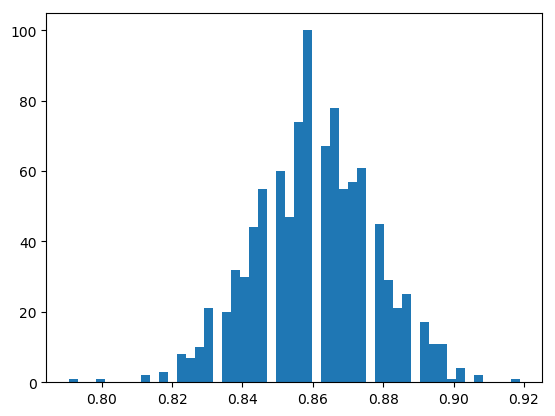


Mean accuracy: 0.8606374999999999
Standard deviation: 0.016871754317497628
Best accuracy value: 0.91875
Worst accuracy value: 0.790625


In [14]:
accuracy_dist = np.zeros(1000)
rand_init = np.zeros(1000)

for i in range(0,1000):
   rand_init[i] = np.floor(np.random.rand(1)[0]*10000)
   X_train, X_test, y_train, y_test = train_test_split(topic_dists, labels, test_size = 0.2, random_state = int(rand_init[i]))
   best_predictions = best_clf.predict(X_test)
   accuracy_dist[i] = accuracy_score(best_predictions,y_test)

plt.hist(accuracy_dist,50)
plt.show()
s = "\nMean accuracy: " + repr(np.mean(accuracy_dist))
print(s)
s = "Standard deviation: " + repr(np.std(accuracy_dist))
print(s)
s = "Best accuracy value: " + repr(np.max(accuracy_dist))
print(s)
s = "Worst accuracy value: " + repr(np.min(accuracy_dist))
print(s)

Accuracies follow a quasi-normal distribution. The mean accuracy is around 0.86 which is pretty decent. Also of note is that the best accuracy is above 0.9 which goes to show that depending on the data we can get very high performance. 

Possible future work: boosting, more involved feature selection stage, further exploration of the parameter space.